# Loan Approval Prediction - Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data

In [2]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

print(f'Training: {train_df.shape}')
print(f'Test: {test_df.shape}')
print(f'Target distribution:')
print(train_df['loan_status'].value_counts(normalize=True))
train_df.head()

Training: (58645, 13)
Test: (39098, 12)
Target distribution:
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## 2. Basic Statistics

In [3]:
print('Data Info:')
train_df.info()
print('Missing values:')
print(train_df.isnull().sum()[train_df.isnull().sum() > 0] if train_df.isnull().sum().any() else 'None')
print('Basic statistics:')
train_df.describe()

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


## 3. Target Distribution

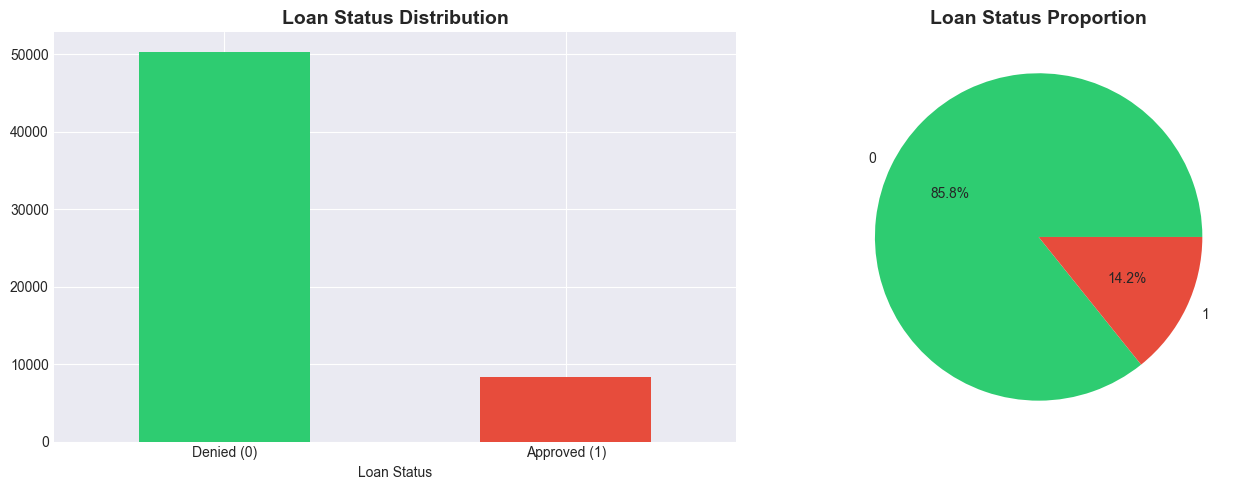

Class Imbalance Ratio (Denied:Approved) = 6.02:1


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
train_df['loan_status'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Loan Status Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status')
axes[0].set_xticklabels(['Denied (0)', 'Approved (1)'], rotation=0)

# Pie chart
train_df['loan_status'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
axes[1].set_title('Loan Status Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

ratio = train_df['loan_status'].value_counts()[0] / train_df['loan_status'].value_counts()[1]
print(f'Class Imbalance Ratio (Denied:Approved) = {ratio:.2f}:1')

## 4. Feature Types

In [5]:
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id')
numerical_cols.remove('loan_status')
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

print(f'Numerical features ({len(numerical_cols)}):')
for col in numerical_cols:
    print(f'  - {col}')
    
print(f'Categorical features ({len(categorical_cols)}):')
for col in categorical_cols:
    print(f'  - {col}: {train_df[col].unique().tolist()}')

Numerical features (7):
  - person_age
  - person_income
  - person_emp_length
  - loan_amnt
  - loan_int_rate
  - loan_percent_income
  - cb_person_cred_hist_length
Categorical features (4):
  - person_home_ownership: ['RENT', 'OWN', 'MORTGAGE', 'OTHER']
  - loan_intent: ['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION', 'HOMEIMPROVEMENT']
  - loan_grade: ['B', 'C', 'A', 'D', 'E', 'F', 'G']
  - cb_person_default_on_file: ['N', 'Y']


## 5. Numerical Features Distribution

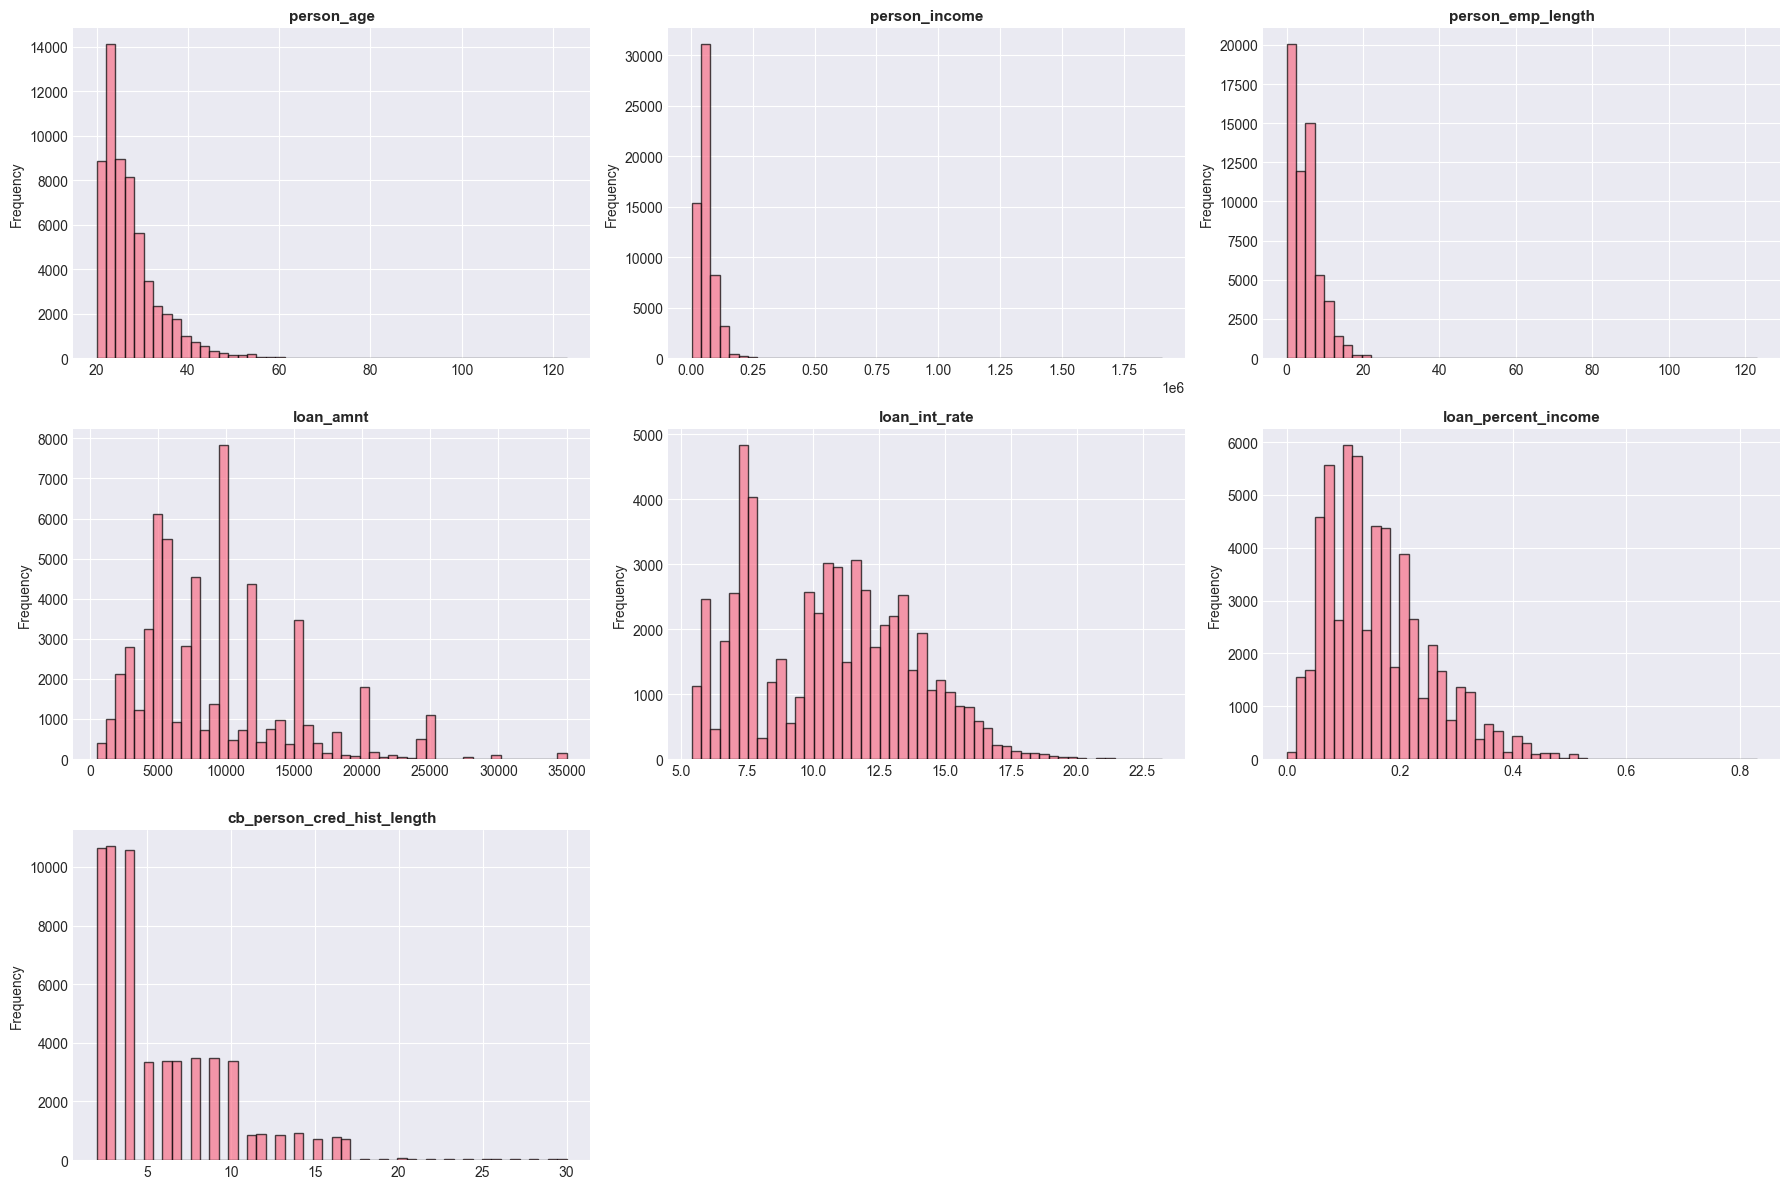

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(train_df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Frequency')

for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])
    
plt.tight_layout()
plt.show()

## 6. Correlation Analysis

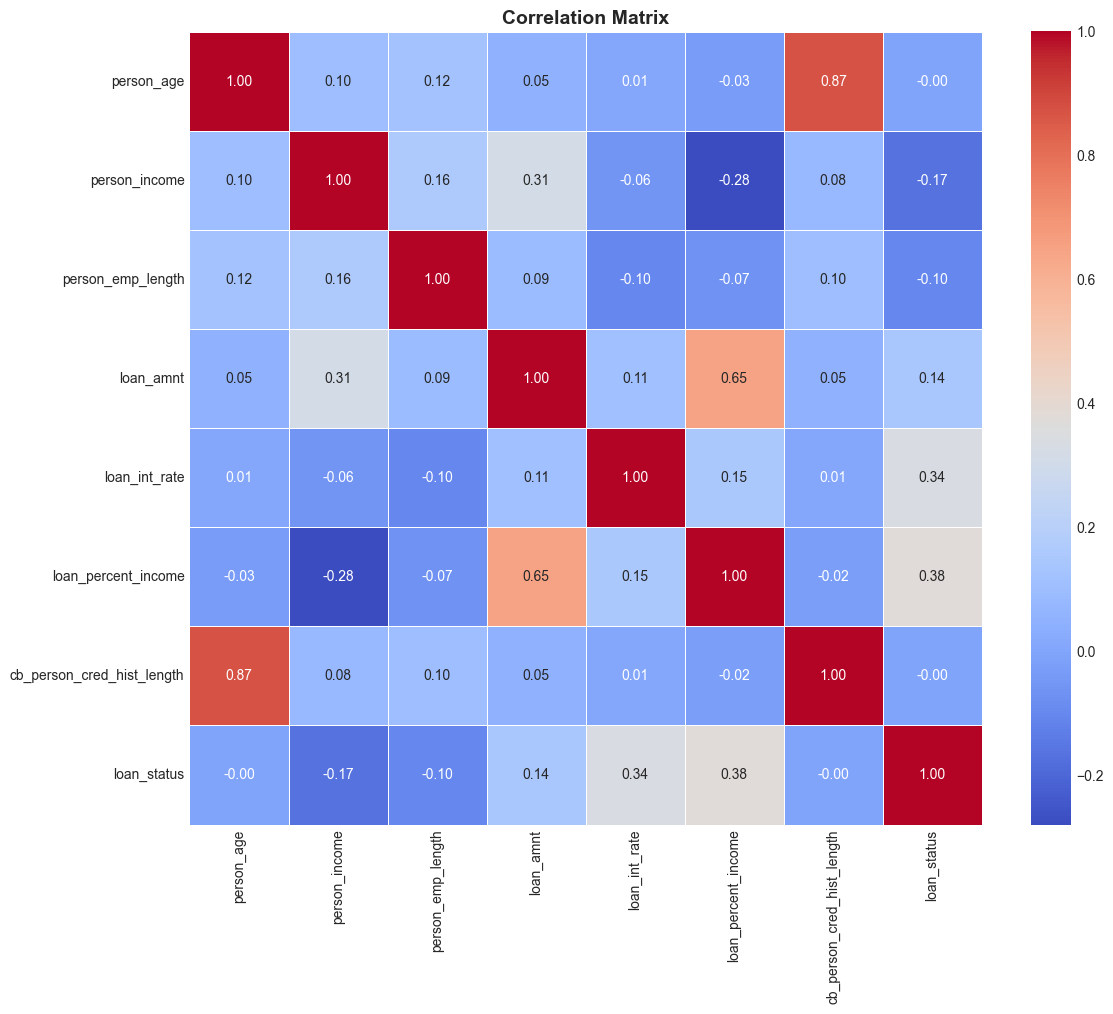

Correlations with loan_status:
loan_status                   1.000000
loan_percent_income           0.378280
loan_int_rate                 0.338948
loan_amnt                     0.144982
person_age                   -0.001130
cb_person_cred_hist_length   -0.003030
person_emp_length            -0.100428
person_income                -0.169956
Name: loan_status, dtype: float64


In [7]:
corr_cols = numerical_cols + ['loan_status']
corr_matrix = train_df[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Correlations with loan_status:')
print(corr_matrix['loan_status'].sort_values(ascending=False))

## 7. Numerical Features by Target

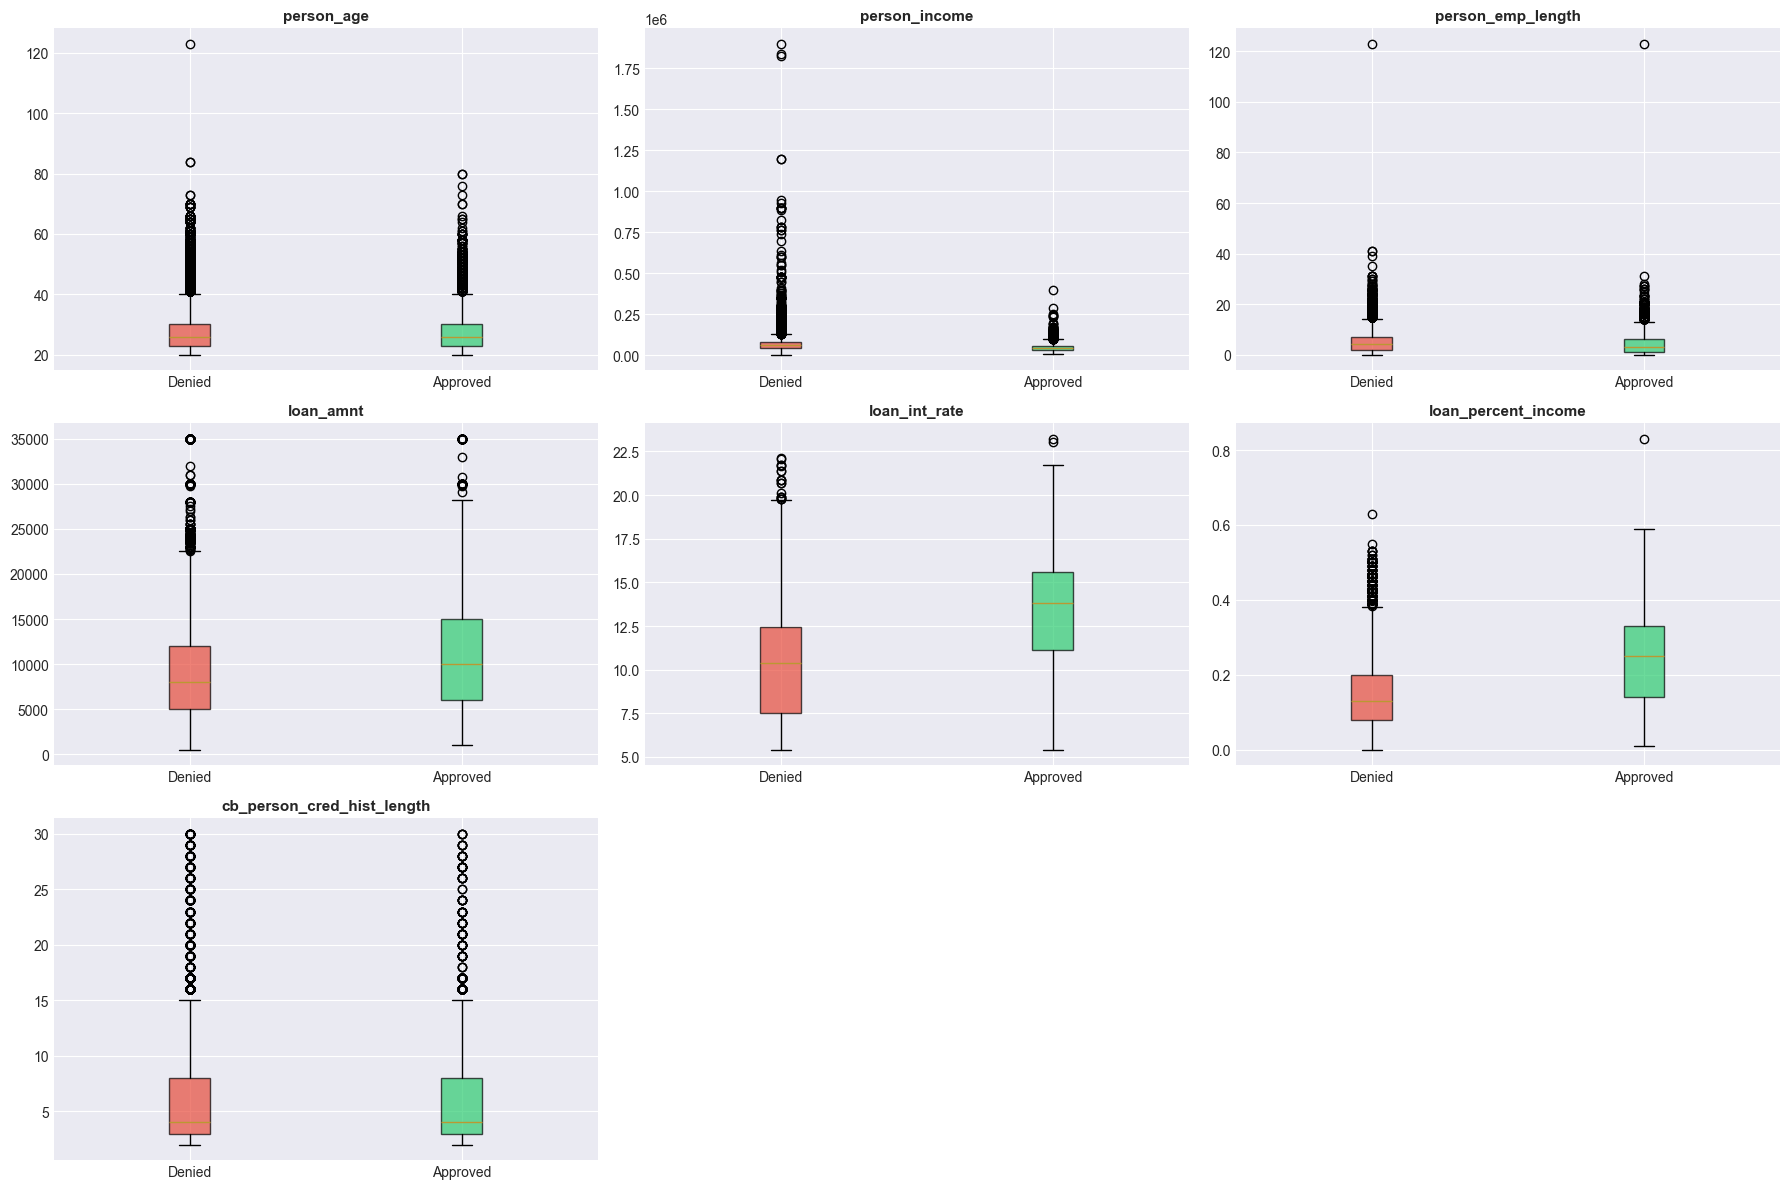

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    data = [train_df[train_df['loan_status'] == 0][col].dropna(),
            train_df[train_df['loan_status'] == 1][col].dropna()]
    
    bp = axes[idx].boxplot(data, labels=['Denied', 'Approved'], patch_artist=True)
    for patch, color in zip(bp['boxes'], ['#e74c3c', '#2ecc71']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_title(col, fontsize=11, fontweight='bold')

for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])
    
plt.tight_layout()
plt.show()

## 8. Categorical Features vs Target

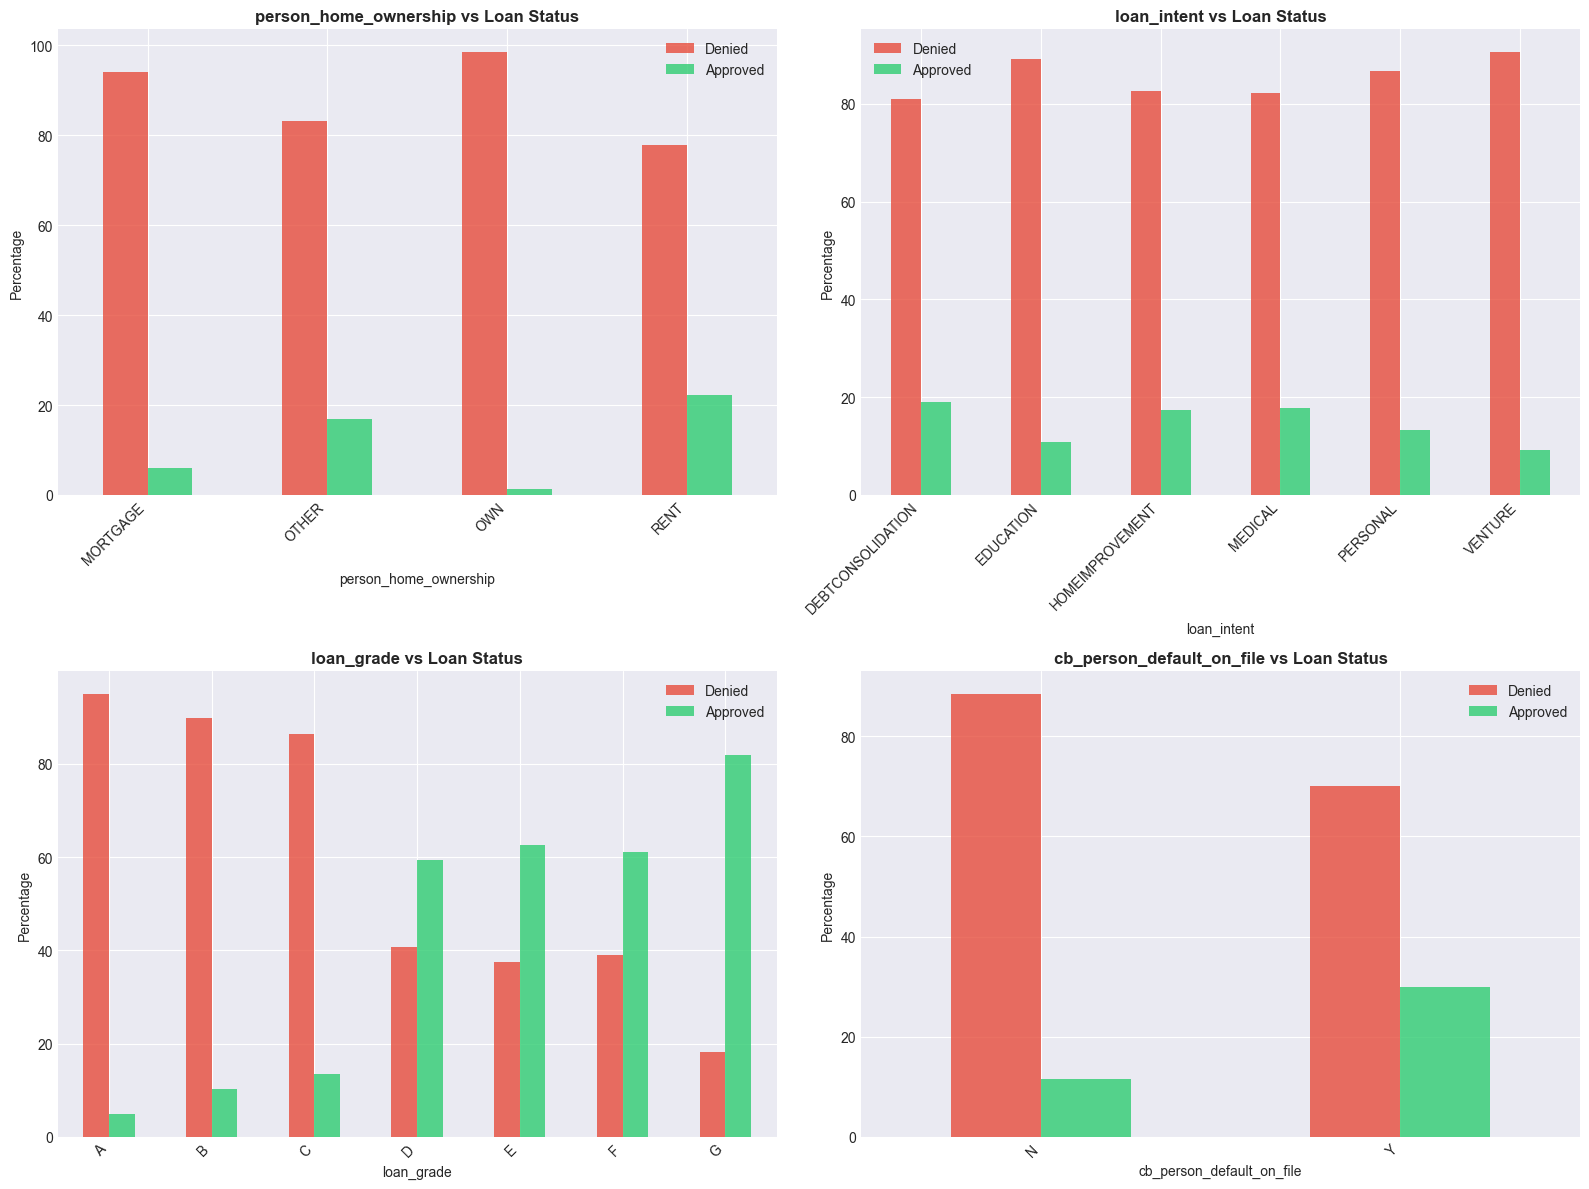

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(categorical_cols):
    ct = pd.crosstab(train_df[col], train_df['loan_status'], normalize='index') * 100
    ct.plot(kind='bar', ax=axes[idx], color=['#e74c3c', '#2ecc71'], alpha=0.8)
    axes[idx].set_title(f'{col} vs Loan Status', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Percentage')
    axes[idx].legend(['Denied', 'Approved'])
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 9. Statistical Significance Tests

In [10]:
print('Mann-Whitney U Test (Numerical Features):')
print('='*70)
for col in numerical_cols:
    g0 = train_df[train_df['loan_status'] == 0][col].dropna()
    g1 = train_df[train_df['loan_status'] == 1][col].dropna()
    stat, p = stats.mannwhitneyu(g0, g1)
    sig = '✓ Significant' if p < 0.05 else 'Not significant'
    print(f'{col:30s} p={p:.6f}  {sig}')

print('Chi-Square Test (Categorical Features):')
print('='*70)
for col in categorical_cols:
    ct = pd.crosstab(train_df[col], train_df['loan_status'])
    chi2, p, dof, _ = chi2_contingency(ct)
    sig = '✓ Significant' if p < 0.05 else 'Not significant'
    print(f'{col:30s} p={p:.6f}  {sig}')

Mann-Whitney U Test (Numerical Features):
person_age                     p=0.000435  ✓ Significant
person_income                  p=0.000000  ✓ Significant
person_emp_length              p=0.000000  ✓ Significant
loan_amnt                      p=0.000000  ✓ Significant
loan_int_rate                  p=0.000000  ✓ Significant
loan_percent_income            p=0.000000  ✓ Significant
cb_person_cred_hist_length     p=0.002038  ✓ Significant
Chi-Square Test (Categorical Features):
person_home_ownership          p=0.000000  ✓ Significant
loan_intent                    p=0.000000  ✓ Significant
loan_grade                     p=0.000000  ✓ Significant
cb_person_default_on_file      p=0.000000  ✓ Significant


## Key Insights

1. **Class Imbalance**: ~86% denied vs 14% approved - will need SMOTE or class weights
2. **Statistical Significance**: All features show significant differences between classes (p < 0.05)
3. **Top Correlations**: loan_percent_income (0.38), loan_int_rate (0.34) most correlated with denial
4. **Data Quality**: No missing values, some outliers in income and age
5. **Next Steps**: Feature engineering, handle imbalance, build models